# Learning Auctions Introduction

In this tutorial, we design, or more aptly learn, auction mechanisms that are approximately revenue optimal while satisfying certain constraints concerning bidder incentives.  The mechanisms themselves will be composed of two networks: an allocation-rule network and a payment-rule network.  This notebook serves as an introduction to the problem domain and focuses on settings were a set of bidders are competing to win a single item via an auction.

## Theoretical framework 
We adopt the framework of [Dutting et al. (2018)](https://arxiv.org/pdf/1706.03459.pdf)

* there are $n$ bidders ($N$) over $m$ items ($M$);
* each bidder $i\in N$ has some value function $v_i: 2^M \rightarrow \mathbb{R}_+$ drawn indepdendently from some distribution $F_i$ over value functions $V_i$;
* the profile of valuations is denoted by $v=(v_1, \ldots, v_n)$;
* the auctioneer knows $F=(F_1, \ldots, F_n)$ but does not know $v$;
* the auctioneer runs a mechanism ($\mathcal{M}=(g,p)$) with allocation rules $g_i: V \rightarrow 2^M$ and payment rules $p_i : V\rightarrow \mathbb{R}_{\ge 0};$
* the auction collects bids $b = (b_1, \ldots , b_n) \in V$, and then computes an allocation $g(b)$ and payments $p(b)$.

We search to design, or more aptly learn, a dominant-strategy incentive-compatible ([DSIC](https://en.wikipedia.org/wiki/Incentive_compatibility)) and individually rational ([IR](https://en.wikipedia.org/wiki/Rational_choice_theory)) mechanism that maximizes expected revenue:

$$
\max_{g,p} E_{v\sim F} \left[\sum_i p(v)\right]\ \ \text{s.t.}\ \ (g,p)\in \text{DSIC},\ \ (g,p)\in \text{IR}
$$

The authors encode the DSIC and IR constraints as follows:

* DSIC: $u_i(v_i, (v_i, b_{−i})) \ge u_i(v_i, (b_i, b_{−i}))$;
* IR: $u_i(v_i,(v_i,b_{−i})) \ge 0$.

## Architectures and supporting functions

### Preliminaries

We will make heavy use of numpy, pandas, and pytorch.

In [13]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')

We will also make use of matplotlib and seaborn for visualization:

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Common components

We add common `dmch` components:

In [15]:
import dmch 


# Init 


In [16]:

"""
Deep Mechanism Components

The dmch package contains data structures and algorithms for deep mechanism design.

The package uses pytorch for underlying tensor operations.
"""


import torch

__author__       = 'Patrick R. Jordan'
__email__        = 'patrick.r.jordan@gmail.com'
__version__      = '0.1.0'
__url__          = 'https://github.com/pjordan/dmch/',
__description__  = 'Deep Mechanism Design Components'

# import to_inputs, from_inputs
# import Allocation, SequentialAllocation, Payment, Mechanism
# import build_allocation_rule, build_payment_rule, build_mechanism, build_spa
# import SequentialMechanism
# import create_spa_mechanism
# from .training import train, evaluate



# Builders 


In [ ]:

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import Module
from torch.nn import Linear

# import Allocation
# import SequentialAllocation
# import Payment
# import Mechanism

# from .spa import create_spa_allocator, create_spa_pricer
# import create_monotonic
# from .sequential import SequentialMechanism

class _LeftAddition(Module):
    def __init__(self, left_transformation):
        super(_LeftAddition, self).__init__()
        self.left_transformation = left_transformation
        
    def forward(self, x):
        return self.left_transformation(x)+x
    
class _BaseBidResponseBuilder(object):
    def __init__(self, bidders, context_features):
        self.bidders = bidders
        self.context_features = context_features
        self.current_features = bidders + context_features
        self.layers = []
    
    def add_identity(self):
        self.layers.append(nn.Identity())
    
    def add_batch_normalization(self):
        self.layers.append(nn.BatchNorm1d(self.current_features))
    
    def add_batch_normalization(self):
        self.layers.append(nn.BatchNorm1d(self.current_features))
        
    def add_sigmoid_activation(self):
        self.layers.append(nn.Sigmoid())
        
    def add_leaky_relu_activation(self):
        self.layers.append(nn.LeakyReLU())
    
    def add_activation(self, act_module):
        self.layers.append(act_module)
        
    def add_linear_layer(self, out_features):
        self.layers.append(nn.Linear(self.current_features, out_features))
        self.current_features = out_features
        
    def add_residual_layer(self, act_layer=nn.LeakyReLU):
        self.layers.append(
            _LeftAddition(
                nn.Sequential(
                    nn.BatchNorm1d(self.current_features),
                    act_layer(),
                    nn.Linear(self.current_features, self.current_features),
                    nn.BatchNorm1d(self.current_features),
                    act_layer(),
                    nn.Linear(self.current_features, self.current_features)
                )
            )
        )
        
    def build(self):
        pass
    
class _AllocationRuleBuilder(_BaseBidResponseBuilder):    
    def build(self):
        layers = self.layers + [Allocation(self.current_features, self.bidders)]
        return nn.Sequential(*layers)
    
    def build_sequential(self,slots,weights=None):
        layers = self.layers + [SequentialAllocation(self.current_features, slots, self.bidders, weights=weights)]
        return nn.Sequential(*layers)
    
class _PaymentRuleBuilder(_BaseBidResponseBuilder):    
    def build(self):
        layers = self.layers + [Payment(self.current_features, self.bidders)]
        return nn.Sequential(*layers)
        
class _MechanismBuilder(object):
    def __init__(self, bidders, context_features=0):
        self.allocation_builder = build_allocation_rule(bidders, context_features=context_features)
        self.payment_builder = build_payment_rule(bidders, context_features=context_features)
    
    def build(self):
        return Mechanism(
            self.allocation_builder.build(),
            self.payment_builder.build())
    
    def build_sequential(self,slots,weights=None):
        return Mechanism(
            self.allocation_builder.build_sequential(slots,weights=weights),
            self.payment_builder.build())
    
class _SpaBuilder(object):
    def __init__(self, bidders, context_features=0):
        self.bidders = bidders
        self.context_features = context_features
        self.virtual_fcn = None
        
    def set_virtual_function(self, hidden_features=1, linear_functions=1, groups=1):
        self.virtual_fcn = create_monotonic(
            context_features=self.context_features,
            hidden_features=hidden_features,
            linear_functions=linear_functions,
            groups=groups)

    def build(self):
        return create_spa_mechanism(self.bidders, context_features=self.context_features)
    
    def build_sequential(self, slots, weights=None):
        return SequentialMechanism(
            [create_spa_allocator(self.bidders) for _ in range(slots)],
            [create_spa_pricer(self.bidders) for _ in range(slots)],
            self.bidders,
            weights=weights,
            virtual_fcn=self.virtual_fcn
        )
    
def build_allocation_rule(bidders, context_features=0):
    return _AllocationRuleBuilder(bidders, context_features=context_features)

def build_payment_rule(bidders, context_features=0):
    return _PaymentRuleBuilder(bidders, context_features=context_features)

def build_mechanism(bidders, context_features=0):
    return _MechanismBuilder(bidders, context_features=context_features)

def build_spa(bidders, context_features=0):
    return _SpaBuilder(bidders, context_features=context_features)



# Common


In [ ]:
import torch

def to_inputs(bids, context):
    return torch.cat((bids,context), dim=1)

def from_inputs(inputs, bidders):
    return torch.split(inputs, (bidders,inputs.shape[1]-bidders), dim=1)
    
def utility(allocation, payment, values):
    return allocation*values-payment

def revenue(payment):
    return payment.sum(dim=-1)

def welfare(allocation, values):
    return (allocation * values).sum(dim=-1)



# Mechanism_modules

In [ ]:
 
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import Module
from torch.nn import Linear

def _sequential_allocation(p, weights):
    _, slots, bidders_plus_one = p.shape
    bidders = bidders_plus_one - 1
    
    # total probability of allocating to slot 0
    cumulative_total = p[:,0,:bidders]
    
    # weighted total allocation
    if weights is None:
        alloc = cumulative_total
    else:
        alloc = cumulative_total * weights[0]
    
    for k in range(1,slots):
        # total probability of allocating to slot k
        slot_total = (1-cumulative_total)*p[:,k,:bidders]*(1-p[:,k-1,[bidders for _ in range(bidders)]])

        # weighted total allocation
        if weights is None:
            alloc = alloc + slot_total
        else:
            alloc = alloc + slot_total * weights[k]
        
        cumulative_total = cumulative_total + slot_total
    return alloc
    
class Allocation(Module):
    r"""Determines allocation probability for each of the bidders given an input.
    
    Args:
        in_features: size of each input sample
        bidders: number of bidders, which governs the size of each output sample
    Shape:
        - Input: :math:`(N, *, H_{in})` where :math:`*` means any number of
          additional dimensions and :math:`H_{in} = \text{in\_features}`
        - Output: :math:`(N, *, H_{out})` where all but the last dimension
          are the same shape as the input and :math:`H_{out} = \text{bidders}`.

    Examples::
        >>> m = Allocation(20, 30)
        >>> input = torch.randn(128, 20)
        >>> allocation = m(input)
        >>> print(allocation.size())
        torch.Size([128, 30])
    """
    __constants__ = ['in_features', 'bidders']
    
    def __init__(self, in_features, bidders):
        super(Allocation, self).__init__()
        self.in_features = in_features
        self.bidders = bidders
        self.linear = Linear(in_features, bidders+1)
        
    def forward(self, x):
        return F.softmax(self.linear(x), dim=1)[:, 0:self.bidders]

class SequentialAllocation(Module):
    __constants__ = ['in_features', 'bidders', 'slots', 'weights']
    
    def __init__(self, in_features, slots, bidders, weights=None):
        super(SequentialAllocation, self).__init__()
        self.in_features = in_features
        self.slots = slots
        self.bidders = bidders
        self.weights = weights
        self.linear = Linear(in_features, slots * (bidders+1))
        
    def forward(self, x):
        probs = F.softmax(self.linear(x).reshape(-1, self.slots, self.bidders+1), dim=2)
        return _sequential_allocation(probs,weights=self.weights)

class Payment(Module):
    r"""Determines the contingent payment for each of the bidders given an input.
    
    Args:
        in_features: size of each input sample
        bidders: number of bidders, which governs the size of each output sample
    Shape:
        - Input: :math:`(N, *, H_{in})` where :math:`*` means any number of
          additional dimensions and :math:`H_{in} = \text{in\_features}`
        - Output: :math:`(N, *, H_{out})` where all but the last dimension
          are the same shape as the input and :math:`H_{out} = \text{bidders}`.

    Examples::
        >>> m = Allocation(20, 30)
        >>> input = torch.randn(128, 20)
        >>> payment = m(input)
        >>> print(payment.size())
        torch.Size([128, 30])
    """
    def __init__(self, in_features, bidders):
        super(Payment, self).__init__()
        self.in_features = in_features
        self.bidders = bidders
        self.linear = Linear(in_features, bidders)
        
    def forward(self, x):
        return self.linear(x)
    
class Mechanism(Module):
    r"""Determines the allocation and payment of the bidders for a given input.
    
    Args:
        allocation: the network govering allocation
        payment: the network governing payment

    """
    def __init__(self, allocation, payment):
        super(Mechanism, self).__init__()
        self.allocation = allocation
        self.payment = payment
        
    def forward(self, x):
        allocation = self.allocation(x)
        return allocation, allocation*self.payment(x)
    



# Monotonic


In [ ]:
import math

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.parameter import Parameter

# import from_inputs


class _ConstantWeightsAndBiases(nn.Module):
    def __init__(self, out_features):
        super(_ConstantWeightsAndBiases, self).__init__()
        self.weights = Parameter(torch.Tensor(out_features, 1))
        self.biases = Parameter(torch.Tensor(out_features, 1))
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.biases, a=math.sqrt(5))
        
    def forward(self, context):
        return self.weights, self.biases
    
class _VariableWeightsAndBiases(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(_VariableWeightsAndBiases, self).__init__()
        self.linear = nn.Linear(in_features, hidden_features)
        self.weights = nn.Linear(hidden_features, out_features)
        self.biases = nn.Linear(hidden_features, out_features)
        
    def forward(self, x):
        x = torch.sigmoid(self.linear(x))
        return self.weights(x), self.biases(x)
    
class Monotonic(nn.Module):
    def __init__(self, hidden_features, linear_functions, groups, context_features=0):
        super(Monotonic, self).__init__()
        self.context_features = context_features
        self.linear_functions = linear_functions
        self.groups = groups
        
        if context_features > 0:
            self.weights_and_biases = _VariableWeightsAndBiases(context_features, hidden_features, linear_functions * groups)
        else:
            self.weights_and_biases = _ConstantWeightsAndBiases(linear_functions * groups)
        
        
    def apply_forward(self, bids, context):
        w, b = self.weights_and_biases(context)
        intermediate = torch.exp(w) * bids + b
        return intermediate.reshape(-1, self.groups, self.linear_functions).max(dim=2)[0].min(dim=1, keepdim=True)[0]
        
    def apply_inverse(self, bids, vbids, context):
        w, b = self.weights_and_biases(context)
        intermediate = torch.exp(-w) * (vbids - b)
        return intermediate.reshape(-1, self.groups, self.linear_functions).min(dim=2)[0].max(dim=1, keepdim=True)[0]
            
    def forward(self, inputs, bids=None, invert=False):
        x, context = from_inputs(inputs,1)
        if invert:
            return self.apply_inverse(bids, x, context)
        else:
            return self.apply_forward(x, context)
        
def create_monotonic(context_features=0, hidden_features=1, linear_functions=1, groups=1):
    return Monotonic(hidden_features, linear_functions, groups, context_features=context_features)



# Sequential


In [ ]:

import torch
import torch.nn as nn
from torch.nn import Module
# from .common import to_inputs
# from .common import from_inputs

def _dot(alist,blist):
    return sum(a*b for a,b in zip(alist,blist))

def cascade_outcomes(allocators, pricers, inputs, bidders):
    bids, context = from_inputs(inputs, bidders)
    allocations, prices = [], []
    cumulative_allocation = None
    prev_allocatinon_prob = None
    
    for allocator, pricer in zip(allocators, pricers):
        slot_inputs = to_inputs(bids, context)
        allocation = allocator(slot_inputs)
        price = pricer(slot_inputs)
        if cumulative_allocation is None:
            allocations.append(allocation)
            prices.append(price)
            cumulative_allocation = allocation
            prev_allocation_prob = torch.cat([allocation.sum(dim=1,keepdim=True) for _ in range(bidders)], dim=1)
        else:
            unconditional_allocation = allocation * (1-cumulative_allocation)*prev_allocation_prob
            allocations.append(unconditional_allocation)
            prices.append(price)
            cumulative_allocation = cumulative_allocation + unconditional_allocation
            prev_allocation_prob = torch.cat([unconditional_allocation.sum(dim=1,keepdim=True) for _ in range(bidders)], dim=1)
        bids = (1-cumulative_allocation) * bids
    return allocations, prices
    
class SequentialMechanism(Module):
    r"""Determines the allocation and payment of the bidders for a given input that allows sequential allocation.
    
    Args:
        mechanisms: the networks govering allocation
        
    """
    def __init__(self, allocators, pricers, bidders, weights=None, virtual_fcn=None):
        super(SequentialMechanism, self).__init__()
        self.allocators = nn.ModuleList(allocators)
        self.pricers = nn.ModuleList(pricers)
        self.weights = weights
        self.bidders = bidders
        self.virtual_fcn = virtual_fcn
        
    def _compute_virtual_bids(self,bids,context):
        return torch.cat(
            [self.virtual_fcn(to_inputs(bids[:,i:(i+1)],context)) for i in range(self.bidders)],
            dim=1)
    
    def _compute_prices(self,vprices,bids,context):
        return torch.cat(
            [self.virtual_fcn(to_inputs(vprices[:,i:(i+1)],context),bids=bids[:,i:(i+1)],invert=True) for i in range(self.bidders)],
            dim=1)
    
    def forward(self, x):
        if self.virtual_fcn is None:
            allocations, prices = cascade_outcomes(self.allocators, self.pricers, x, self.bidders)
        else:
            bids, context = from_inputs(x, self.bidders)
            vbids = self._compute_virtual_bids(bids, context)
            vx = to_inputs(vbids,context)
            allocations, vprices = cascade_outcomes(self.allocators, self.pricers, vx, self.bidders)
            prices = [self._compute_prices(vprices[i], bids, context) for i in range(len(vprices))]
            
        payments = [a*p for a,p in zip(allocations, prices)]
        if self.weights:
            return _dot(self.weights, allocations), _dot(self.weights, payments)
        else:
            return sum(allocations), sum(payments)
 

# Spa
 


In [ ]:
import torch
import torch.nn as nn
# from . import Mechanism
# from . import from_inputs

class _SpaAllocation(nn.Module):
    def __init__(self, bidders, kappa=1e4):
        super(_SpaAllocation, self).__init__()
        self.kappa = kappa
        self.bidders = bidders
        
    def forward(self, x):
        bids, _ = from_inputs(x, self.bidders)
        device = bids.get_device()
        bids_plus_dummy = torch.cat([bids, torch.zeros(bids.shape[0],1).to(device)], dim=1)
        return torch.softmax(self.kappa*bids_plus_dummy, dim=1)[:,:-1]

class _SpaPayment(nn.Module):
    def __init__(self, bidders):
        super(_SpaPayment, self).__init__()
        self.bidders = bidders
    def forward(self, x):
        bids, _ = from_inputs(x, self.bidders)
        device = x.get_device()
        return torch.stack([bids.index_fill(1,torch.tensor([col]).to(device),0).max(dim=1)[0] for col in range(bids.shape[1])], dim=1)
    
def create_spa_allocator(bidders,kappa=1e4):
    return _SpaAllocation(bidders,kappa=kappa)

def create_spa_pricer(bidders):
    return _SpaPayment(bidders,)

def create_spa_mechanism(bidders,kappa=1e4):
    return Mechanism(
        create_spa_allocator(bidders,kappa=1e4),
        create_spa_pricer(bidders))

# bidders = 2
# def create_regret_net(bidders, hidden_layers=2, hidden_units=10):
#     mbuilder = build_mechanism(bidders)
    
#     # create a layer to correctly size the hidden layers
#     mbuilder.allocation_builder.add_linear_layer(hidden_units)
#     mbuilder.payment_builder.add_linear_layer(hidden_units)
    
#     for _ in range(hidden_layers):
#         mbuilder.allocation_builder.add_linear_layer(hidden_units)
#         mbuilder.payment_builder.add_linear_layer(hidden_units)
#         mbuilder.allocation_builder.add_activation(nn.Sigmoid())
#         mbuilder.payment_builder.add_activation(nn.Sigmoid())
    
#     return mbuilder.build()
 



# Training


In [ ]:

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from tqdm import tqdm
import torch.utils.data as data_utils
import numpy as np
import pandas as pd

# Om dit te kunnen runnen 


sample_size = 10 #2**11
batch_size = 2 #2**8
bidders = 1

inputs_loader=data_utils.DataLoader(
    data_utils.TensorDataset(torch.rand(sample_size, bidders)),
    batch_size=batch_size)
data_list = []
for batch_idx, batch in enumerate(inputs_loader):
    data_list.append(batch[0].numpy())

# Concatenate the data and create a DataFrame
data = np.concatenate(data_list, axis=0)
df = pd.DataFrame(data)

print(df)

def _calc_utility(inputs, mechanism, values, output_components=False):
    allocation, payment = mechanism(inputs)
    if output_components:
        return allocation*values-payment, allocation, payment
    else:
        return allocation*values-payment
    
def _calc_regret(inputs, mechanism, misreport, bidders, device, leaky=False):
    values, context = from_inputs(inputs, bidders)
    u_true, a_true, p_true = _calc_utility(inputs, mechanism, values, output_components=True)
    regret = torch.zeros(values.shape).to(device)
    for bidder in range(bidders):
        bidder_mask = torch.zeros(values.shape).to(device)
        bidder_mask[:,bidder] = 1.0
        response = misreport * bidder_mask + values * (1-bidder_mask)
        u_response = _calc_utility(to_inputs(response,context), mechanism, values)
        if leaky:
            regret = regret + F.leaky_relu((u_response - u_true) * bidder_mask)
        else:
            regret = regret + F.relu((u_response - u_true) * bidder_mask)
    return regret.mean(dim=0)

def _best_misreport(values, inputs, mechanism, bidders, device, misreport_lr, misreport_epochs):
    misreport = (torch.FloatTensor(values.shape).uniform_(0, 1).to(device) * values).detach().requires_grad_(True)
    misreport_optimizer = optim.Adam([misreport], lr=misreport_lr)
            
    mechanism.eval()
    for _ in range(misreport_epochs):
        misreport_optimizer.zero_grad()
        regret = _calc_regret(
            inputs, 
            mechanism,
            misreport,
            bidders,
            device,
            leaky=True)
        (-regret.sum()).backward()
        nn.utils.clip_grad_norm_([misreport], 1.0)
        misreport_optimizer.step()
    mechanism.train()
    return misreport.detach().clone().requires_grad_(False)

def train(mechanism, values_loader, bidders, **kwargs):
    # load parameters
    device = kwargs['device'] if 'device' in kwargs else 'cpu'
    epochs = kwargs['epochs'] if 'epochs' in kwargs else 1
    rho = kwargs['rho'] if 'rho' in kwargs else 100
    mechanism_lr = kwargs['mechanism_lr'] if 'mechanism_lr' in kwargs else 1e-3
    misreport_lr = kwargs['misreport_lr'] if 'misreport_lr' in kwargs else 1e-3
    misreport_epochs = kwargs['misreport_epochs'] if 'misreport_epochs' in kwargs else 10
    consider_dsic = kwargs['consider_dsic'] if 'consider_dsic' in kwargs else True
    consider_ir = kwargs['consider_ir'] if 'consider_ir' in kwargs else True
    
    # Initialize augmented lagrangian parameters
    if consider_dsic:
        lambda_dsic = torch.zeros(bidders).to(device)
    if consider_ir:
        lambda_ir   = torch.zeros(bidders).to(device)

    # Initalize the optimizer
    mechanism_optimizer = optim.Adam(mechanism.parameters(), lr=mechanism_lr)
    
    report_data = []

    for epoch in tqdm(range(epochs)):
        for batch_idx,(values_list) in enumerate(values_loader):
            inputs = values_list[0].to(device)
            values, context = from_inputs(inputs, bidders)
            print(values)
            if consider_dsic:
                misreport = _best_misreport(
                    values, 
                    inputs, 
                    mechanism, 
                    bidders, 
                    device, 
                    misreport_lr, 
                    misreport_epochs)

            # Start the gradient computation
            mechanism.zero_grad()
            
            # calculate the utilities and prices
            utility, allocation, payment = _calc_utility(
                inputs, mechanism, values, output_components=True)
    
            if consider_dsic:
                # compute expected regret 
                dsic_violation = _calc_regret(
                    inputs,
                    mechanism,
                    misreport,
                    bidders,
                    device)
            
            if consider_ir:
                # compute individual rationality violation
                ir_violation = F.relu(-utility).mean(dim=0)
    
            # compute components of the loss function
            revenue = payment.sum(dim=-1).mean()
            
            if consider_dsic:
                total_dsic_violation = dsic_violation.sum()
            
            if consider_ir:
                total_ir_violation = ir_violation.sum()
            
            total_violation = 0
            if consider_dsic:
                total_violation += total_dsic_violation.pow(2)
                
            if consider_ir:
                total_violation += total_ir_violation.pow(2)
                
            # define the loss 
            loss = -revenue+0.5*rho*(total_violation)
            
            if consider_dsic:
                loss += (lambda_dsic*dsic_violation).sum()
                
            if consider_ir:
                loss += (lambda_ir*ir_violation).sum()
                
            
            # Trigger the autogradient calculation
            loss.backward()
        
            # Clip the norm to prevent exploding gradients
            nn.utils.clip_grad_norm_(mechanism.parameters(), 1.0)
            
            # Take a step towards the gradient
            mechanism_optimizer.step()
            
            mechanism.eval()
            
            if consider_dsic:
                misreport = _best_misreport(
                    values, 
                    inputs, 
                    mechanism, 
                    bidders, 
                    device, 
                    misreport_lr, 
                    misreport_epochs)
            
                # Update the augmented lagrangian parameters
                dsic_violation_next = _calc_regret(
                    inputs,
                    mechanism,
                    misreport,
                    bidders,
                    device)
                lambda_dsic = (lambda_dsic + rho * dsic_violation_next).detach()
            
            if consider_ir:
                u_next = _calc_utility(inputs, mechanism, values)
                ir_violation_next = F.relu(-u_next).mean(dim=0)
            
                lambda_ir = (lambda_ir + rho * ir_violation_next).detach()
            
            mechanism.train()
            
            report_item = {
                'epoch': epoch,
                'batch': batch_idx,
                'revenue':revenue.item(),
                'loss':loss.item()}
            
            if consider_dsic:
                report_item['total_dsic_violation']=total_dsic_violation.item()
            
            if consider_ir:
                report_item['total_ir_violation']=total_ir_violation.item()
                
            report_data.append(report_item)
    #print(report_data)    
    return report_data


def evaluate(mechanism, inputs_loader, bidders, **kwargs):
    # load parameters
    device = kwargs['device'] if 'device' in kwargs else 'cpu'
    misreport_lr = kwargs['misreport_lr'] if 'misreport_lr' in kwargs else 1e-3
    misreport_epochs = kwargs['misreport_epochs'] if 'misreport_epochs' in kwargs else 10
    consider_dsic = kwargs['consider_dsic'] if 'consider_dsic' in kwargs else True
    consider_ir = kwargs['consider_ir'] if 'consider_ir' in kwargs else True
    
    report_data = []

    mechanism.eval()
    for batch_idx,(input_list) in enumerate(inputs_loader):
        inputs = input_list[0].to(device)
        values, context = from_inputs(inputs, bidders)
        
        if consider_dsic:
            misreport = _best_misreport(
                values, 
                inputs, 
                mechanism, 
                bidders, 
                device, 
                misreport_lr, 
                misreport_epochs)
            
        # calculate the utilities and prices
        utility, allocation, payment = _calc_utility(
            inputs, mechanism, values, output_components=True)
    
        if consider_dsic:
            # compute expected regret 
            dsic_violation = _calc_regret(
                inputs,
                mechanism,
                misreport,
                bidders,
                device)
    
        if consider_ir:
            # compute individual rationality violation
            ir_violation = F.relu(-utility).mean(dim=0)
    
        # compute components of the loss function
        revenue = payment.sum(dim=-1).mean()
        
        if consider_dsic:
            total_dsic_violation = dsic_violation.sum()
        
        if consider_ir:
            total_ir_violation = ir_violation.sum()
        
        report_item = {
            'batch': batch_idx,
            'revenue':revenue.item(),
        }
        
        if consider_dsic:
            report_item['total_dsic_violation']=total_dsic_violation.item()
            
        if consider_ir:
            report_item['total_ir_violation']=total_ir_violation.item()
            
        report_data.append(report_item)
        
    mechanism.train()        
    return report_data





In [ ]:
# report = pd.DataFrame(train(
#     regret_net, # the mechanism
#     inputs_loader, # the bid inputs
#     bidders, # the number of bidders
#     epochs=10, # the total number of loops over the data
#     device=device, # the device
#     rho=1e2, # the rho parameter for the augmented Lagrangian method
#     mechanism_lr=1e-2, # the learning rate for the mechanism networks
#     misreport_lr=1e-1, # the learning rate for the misreport tensor
#     misreport_epochs=10)) # the number of epochs to tune the misreport tensor for each batch


## RegretNet

[Dutting et al. (2018)](https://arxiv.org/pdf/1706.03459.pdf) proposed a network of the following form. Here we have reduced the number of nodes in the hidden layers. 

In [42]:
def create_regret_net(bidders, hidden_layers=2, hidden_units=10):
    mbuilder = build_mechanism(bidders)
    
    # create a layer to correctly size the hidden layers
    mbuilder.allocation_builder.add_linear_layer(hidden_units)
    mbuilder.payment_builder.add_linear_layer(hidden_units)
    
    for _ in range(hidden_layers):
        mbuilder.allocation_builder.add_linear_layer(hidden_units)
        mbuilder.payment_builder.add_linear_layer(hidden_units)
        mbuilder.allocation_builder.add_activation(nn.Sigmoid())
        mbuilder.payment_builder.add_activation(nn.Sigmoid())
    
    return mbuilder.build()

## Single-Item Auction

In the samples below, we evaluate RegretNet on standard auction scenarios.  In each case, bidders valuations are drawn independently from $U[0,1]$.

### Single Bidder

For our warmup exercise, we consider only a single bidder.  From Myerson (81), we know that the optimal mechanism is a fixed price of 0.5.  Since the bidders values are drawn from uniformly from [0,1], we know that half of the draws will result in the bidder passing on the item, with the other half accepting at a price of 0.5.  Therefore, the optimal expected revenue is 0.25.

In [48]:
bidders = 1

The networks will train on data that is sampled from the value distribution, which is loaded into a `DataLoader`.

In [49]:
import torch.utils.data as data_utils
import torch

sample_size = 2**11
batch_size = 2**8

#data is created, the data consists of batches of size 2**8, till all the 2**11 points are fullfilled and with the amount of bidders! 
inputs_loader=data_utils.DataLoader(
    data_utils.TensorDataset(torch.rand(sample_size, bidders)),
    batch_size=batch_size)

We construct the mechanism from the `dmch` builder.

In [50]:
regret_net = create_regret_net(bidders).to(device)

A summary of the mechanism network is given below with a total for 513 trainable parameter.

In [53]:
summary(regret_net, (1,bidders))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 10]              20
            Linear-2                [-1, 1, 10]             110
           Sigmoid-3                [-1, 1, 10]               0
            Linear-4                [-1, 1, 10]             110
           Sigmoid-5                [-1, 1, 10]               0
            Linear-6                 [-1, 1, 2]              22
        Allocation-7                 [-1, 1, 2]               0
            Linear-8                [-1, 1, 10]              20
            Linear-9                [-1, 1, 10]             110
          Sigmoid-10                [-1, 1, 10]               0
           Linear-11                [-1, 1, 10]             110
          Sigmoid-12                [-1, 1, 10]               0
           Linear-13                 [-1, 1, 1]              11
          Payment-14                 [-

We loop over the data for a number of epochs and record traces of the networks learning.

In [32]:
report = pd.DataFrame(train(
    regret_net, # the mechanism
    inputs_loader, # the bid inputs
    bidders, # the number of bidders
    epochs=10, # the total number of loops over the data
    device=device, # the device
    rho=1e2, # the rho parameter for the augmented Lagrangian method
    mechanism_lr=1e-2, # the learning rate for the mechanism networks
    misreport_lr=1e-1, # the learning rate for the misreport tensor
    misreport_epochs=10)) # the number of epochs to tune the misreport tensor for each batch

  0%|          | 0/1000 [00:00<?, ?it/s]

tensor([[1.1226e-02],
        [6.6864e-01],
        [2.9400e-01],
        [7.5736e-01],
        [4.0182e-01],
        [1.5875e-01],
        [1.1305e-02],
        [8.1991e-02],
        [4.4618e-01],
        [7.8996e-01],
        [1.7326e-01],
        [4.0272e-01],
        [4.7099e-01],
        [6.0690e-01],
        [2.9067e-01],
        [3.0776e-01],
        [4.6891e-01],
        [4.2644e-01],
        [1.4741e-01],
        [8.5892e-01],
        [1.9030e-01],
        [7.5136e-01],
        [8.2872e-02],
        [8.1354e-01],
        [1.7046e-01],
        [8.3551e-01],
        [6.6600e-01],
        [8.0986e-01],
        [5.1740e-01],
        [2.4107e-01],
        [6.2173e-01],
        [8.5528e-01],
        [1.6840e-01],
        [9.2368e-01],
        [6.6680e-01],
        [2.1876e-01],
        [6.0547e-01],
        [1.7080e-01],
        [5.0409e-01],
        [1.6458e-01],
        [2.9401e-01],
        [7.2141e-01],
        [4.5073e-01],
        [5.4135e-01],
        [4.9546e-01],
        [3

  0%|          | 1/1000 [00:00<08:49,  1.89it/s]

tensor([[1.1643e-01],
        [3.8235e-01],
        [8.7349e-01],
        [8.5476e-01],
        [7.1813e-01],
        [5.3875e-01],
        [3.8897e-01],
        [2.9182e-01],
        [7.0346e-01],
        [6.9440e-01],
        [2.3110e-01],
        [9.6136e-01],
        [3.0609e-01],
        [1.8189e-01],
        [5.2521e-02],
        [1.5629e-01],
        [1.9537e-01],
        [2.3819e-01],
        [9.9920e-01],
        [3.3670e-01],
        [6.0712e-01],
        [1.2410e-01],
        [2.3390e-01],
        [8.6100e-01],
        [8.4737e-01],
        [8.0342e-01],
        [8.6781e-01],
        [6.6997e-01],
        [6.2971e-01],
        [6.9291e-01],
        [5.2940e-01],
        [6.4402e-01],
        [5.3225e-01],
        [3.1101e-01],
        [5.8915e-02],
        [6.1360e-02],
        [1.6285e-01],
        [9.9469e-01],
        [1.2190e-01],
        [4.2737e-01],
        [2.9323e-01],
        [5.3393e-01],
        [9.2649e-01],
        [9.1884e-01],
        [5.5390e-01],
        [1

  0%|          | 2/1000 [00:00<07:50,  2.12it/s]

tensor([[1.1643e-01],
        [3.8235e-01],
        [8.7349e-01],
        [8.5476e-01],
        [7.1813e-01],
        [5.3875e-01],
        [3.8897e-01],
        [2.9182e-01],
        [7.0346e-01],
        [6.9440e-01],
        [2.3110e-01],
        [9.6136e-01],
        [3.0609e-01],
        [1.8189e-01],
        [5.2521e-02],
        [1.5629e-01],
        [1.9537e-01],
        [2.3819e-01],
        [9.9920e-01],
        [3.3670e-01],
        [6.0712e-01],
        [1.2410e-01],
        [2.3390e-01],
        [8.6100e-01],
        [8.4737e-01],
        [8.0342e-01],
        [8.6781e-01],
        [6.6997e-01],
        [6.2971e-01],
        [6.9291e-01],
        [5.2940e-01],
        [6.4402e-01],
        [5.3225e-01],
        [3.1101e-01],
        [5.8915e-02],
        [6.1360e-02],
        [1.6285e-01],
        [9.9469e-01],
        [1.2190e-01],
        [4.2737e-01],
        [2.9323e-01],
        [5.3393e-01],
        [9.2649e-01],
        [9.1884e-01],
        [5.5390e-01],
        [1

  0%|          | 3/1000 [00:01<07:42,  2.16it/s]

tensor([[1.1643e-01],
        [3.8235e-01],
        [8.7349e-01],
        [8.5476e-01],
        [7.1813e-01],
        [5.3875e-01],
        [3.8897e-01],
        [2.9182e-01],
        [7.0346e-01],
        [6.9440e-01],
        [2.3110e-01],
        [9.6136e-01],
        [3.0609e-01],
        [1.8189e-01],
        [5.2521e-02],
        [1.5629e-01],
        [1.9537e-01],
        [2.3819e-01],
        [9.9920e-01],
        [3.3670e-01],
        [6.0712e-01],
        [1.2410e-01],
        [2.3390e-01],
        [8.6100e-01],
        [8.4737e-01],
        [8.0342e-01],
        [8.6781e-01],
        [6.6997e-01],
        [6.2971e-01],
        [6.9291e-01],
        [5.2940e-01],
        [6.4402e-01],
        [5.3225e-01],
        [3.1101e-01],
        [5.8915e-02],
        [6.1360e-02],
        [1.6285e-01],
        [9.9469e-01],
        [1.2190e-01],
        [4.2737e-01],
        [2.9323e-01],
        [5.3393e-01],
        [9.2649e-01],
        [9.1884e-01],
        [5.5390e-01],
        [1

  0%|          | 4/1000 [00:01<07:33,  2.20it/s]

tensor([[1.1643e-01],
        [3.8235e-01],
        [8.7349e-01],
        [8.5476e-01],
        [7.1813e-01],
        [5.3875e-01],
        [3.8897e-01],
        [2.9182e-01],
        [7.0346e-01],
        [6.9440e-01],
        [2.3110e-01],
        [9.6136e-01],
        [3.0609e-01],
        [1.8189e-01],
        [5.2521e-02],
        [1.5629e-01],
        [1.9537e-01],
        [2.3819e-01],
        [9.9920e-01],
        [3.3670e-01],
        [6.0712e-01],
        [1.2410e-01],
        [2.3390e-01],
        [8.6100e-01],
        [8.4737e-01],
        [8.0342e-01],
        [8.6781e-01],
        [6.6997e-01],
        [6.2971e-01],
        [6.9291e-01],
        [5.2940e-01],
        [6.4402e-01],
        [5.3225e-01],
        [3.1101e-01],
        [5.8915e-02],
        [6.1360e-02],
        [1.6285e-01],
        [9.9469e-01],
        [1.2190e-01],
        [4.2737e-01],
        [2.9323e-01],
        [5.3393e-01],
        [9.2649e-01],
        [9.1884e-01],
        [5.5390e-01],
        [1

  0%|          | 5/1000 [00:02<07:20,  2.26it/s]

tensor([[1.1226e-02],
        [6.6864e-01],
        [2.9400e-01],
        [7.5736e-01],
        [4.0182e-01],
        [1.5875e-01],
        [1.1305e-02],
        [8.1991e-02],
        [4.4618e-01],
        [7.8996e-01],
        [1.7326e-01],
        [4.0272e-01],
        [4.7099e-01],
        [6.0690e-01],
        [2.9067e-01],
        [3.0776e-01],
        [4.6891e-01],
        [4.2644e-01],
        [1.4741e-01],
        [8.5892e-01],
        [1.9030e-01],
        [7.5136e-01],
        [8.2872e-02],
        [8.1354e-01],
        [1.7046e-01],
        [8.3551e-01],
        [6.6600e-01],
        [8.0986e-01],
        [5.1740e-01],
        [2.4107e-01],
        [6.2173e-01],
        [8.5528e-01],
        [1.6840e-01],
        [9.2368e-01],
        [6.6680e-01],
        [2.1876e-01],
        [6.0547e-01],
        [1.7080e-01],
        [5.0409e-01],
        [1.6458e-01],
        [2.9401e-01],
        [7.2141e-01],
        [4.5073e-01],
        [5.4135e-01],
        [4.9546e-01],
        [3

  1%|          | 6/1000 [00:02<07:15,  2.28it/s]

tensor([[1.1226e-02],
        [6.6864e-01],
        [2.9400e-01],
        [7.5736e-01],
        [4.0182e-01],
        [1.5875e-01],
        [1.1305e-02],
        [8.1991e-02],
        [4.4618e-01],
        [7.8996e-01],
        [1.7326e-01],
        [4.0272e-01],
        [4.7099e-01],
        [6.0690e-01],
        [2.9067e-01],
        [3.0776e-01],
        [4.6891e-01],
        [4.2644e-01],
        [1.4741e-01],
        [8.5892e-01],
        [1.9030e-01],
        [7.5136e-01],
        [8.2872e-02],
        [8.1354e-01],
        [1.7046e-01],
        [8.3551e-01],
        [6.6600e-01],
        [8.0986e-01],
        [5.1740e-01],
        [2.4107e-01],
        [6.2173e-01],
        [8.5528e-01],
        [1.6840e-01],
        [9.2368e-01],
        [6.6680e-01],
        [2.1876e-01],
        [6.0547e-01],
        [1.7080e-01],
        [5.0409e-01],
        [1.6458e-01],
        [2.9401e-01],
        [7.2141e-01],
        [4.5073e-01],
        [5.4135e-01],
        [4.9546e-01],
        [3

  1%|          | 7/1000 [00:03<07:10,  2.30it/s]

tensor([[1.1226e-02],
        [6.6864e-01],
        [2.9400e-01],
        [7.5736e-01],
        [4.0182e-01],
        [1.5875e-01],
        [1.1305e-02],
        [8.1991e-02],
        [4.4618e-01],
        [7.8996e-01],
        [1.7326e-01],
        [4.0272e-01],
        [4.7099e-01],
        [6.0690e-01],
        [2.9067e-01],
        [3.0776e-01],
        [4.6891e-01],
        [4.2644e-01],
        [1.4741e-01],
        [8.5892e-01],
        [1.9030e-01],
        [7.5136e-01],
        [8.2872e-02],
        [8.1354e-01],
        [1.7046e-01],
        [8.3551e-01],
        [6.6600e-01],
        [8.0986e-01],
        [5.1740e-01],
        [2.4107e-01],
        [6.2173e-01],
        [8.5528e-01],
        [1.6840e-01],
        [9.2368e-01],
        [6.6680e-01],
        [2.1876e-01],
        [6.0547e-01],
        [1.7080e-01],
        [5.0409e-01],
        [1.6458e-01],
        [2.9401e-01],
        [7.2141e-01],
        [4.5073e-01],
        [5.4135e-01],
        [4.9546e-01],
        [3

  1%|          | 8/1000 [00:03<07:00,  2.36it/s]

tensor([[0.7496],
        [0.3979],
        [0.9210],
        [0.5736],
        [0.0927],
        [0.5807],
        [0.3725],
        [0.7551],
        [0.4319],
        [0.1941],
        [0.7356],
        [0.9264],
        [0.9355],
        [0.0666],
        [0.8508],
        [0.5513],
        [0.7137],
        [0.2214],
        [0.1567],
        [0.4736],
        [0.9259],
        [0.4633],
        [0.8027],
        [0.0987],
        [0.8115],
        [0.4657],
        [0.2894],
        [0.6584],
        [0.1340],
        [0.3971],
        [0.5104],
        [0.6683],
        [0.3262],
        [0.2594],
        [0.9178],
        [0.2841],
        [0.4710],
        [0.4010],
        [0.3667],
        [0.1337],
        [0.7000],
        [0.6238],
        [0.9908],
        [0.0490],
        [0.5164],
        [0.0814],
        [0.6554],
        [0.5589],
        [0.4050],
        [0.0408],
        [0.0885],
        [0.5631],
        [0.9971],
        [0.7913],
        [0.0633],
        [0

  1%|          | 9/1000 [00:03<07:01,  2.35it/s]

tensor([[0.7496],
        [0.3979],
        [0.9210],
        [0.5736],
        [0.0927],
        [0.5807],
        [0.3725],
        [0.7551],
        [0.4319],
        [0.1941],
        [0.7356],
        [0.9264],
        [0.9355],
        [0.0666],
        [0.8508],
        [0.5513],
        [0.7137],
        [0.2214],
        [0.1567],
        [0.4736],
        [0.9259],
        [0.4633],
        [0.8027],
        [0.0987],
        [0.8115],
        [0.4657],
        [0.2894],
        [0.6584],
        [0.1340],
        [0.3971],
        [0.5104],
        [0.6683],
        [0.3262],
        [0.2594],
        [0.9178],
        [0.2841],
        [0.4710],
        [0.4010],
        [0.3667],
        [0.1337],
        [0.7000],
        [0.6238],
        [0.9908],
        [0.0490],
        [0.5164],
        [0.0814],
        [0.6554],
        [0.5589],
        [0.4050],
        [0.0408],
        [0.0885],
        [0.5631],
        [0.9971],
        [0.7913],
        [0.0633],
        [0

  1%|          | 10/1000 [00:04<07:05,  2.33it/s]

tensor([[0.7496],
        [0.3979],
        [0.9210],
        [0.5736],
        [0.0927],
        [0.5807],
        [0.3725],
        [0.7551],
        [0.4319],
        [0.1941],
        [0.7356],
        [0.9264],
        [0.9355],
        [0.0666],
        [0.8508],
        [0.5513],
        [0.7137],
        [0.2214],
        [0.1567],
        [0.4736],
        [0.9259],
        [0.4633],
        [0.8027],
        [0.0987],
        [0.8115],
        [0.4657],
        [0.2894],
        [0.6584],
        [0.1340],
        [0.3971],
        [0.5104],
        [0.6683],
        [0.3262],
        [0.2594],
        [0.9178],
        [0.2841],
        [0.4710],
        [0.4010],
        [0.3667],
        [0.1337],
        [0.7000],
        [0.6238],
        [0.9908],
        [0.0490],
        [0.5164],
        [0.0814],
        [0.6554],
        [0.5589],
        [0.4050],
        [0.0408],
        [0.0885],
        [0.5631],
        [0.9971],
        [0.7913],
        [0.0633],
        [0

  1%|          | 11/1000 [00:04<07:06,  2.32it/s]

tensor([[0.7496],
        [0.3979],
        [0.9210],
        [0.5736],
        [0.0927],
        [0.5807],
        [0.3725],
        [0.7551],
        [0.4319],
        [0.1941],
        [0.7356],
        [0.9264],
        [0.9355],
        [0.0666],
        [0.8508],
        [0.5513],
        [0.7137],
        [0.2214],
        [0.1567],
        [0.4736],
        [0.9259],
        [0.4633],
        [0.8027],
        [0.0987],
        [0.8115],
        [0.4657],
        [0.2894],
        [0.6584],
        [0.1340],
        [0.3971],
        [0.5104],
        [0.6683],
        [0.3262],
        [0.2594],
        [0.9178],
        [0.2841],
        [0.4710],
        [0.4010],
        [0.3667],
        [0.1337],
        [0.7000],
        [0.6238],
        [0.9908],
        [0.0490],
        [0.5164],
        [0.0814],
        [0.6554],
        [0.5589],
        [0.4050],
        [0.0408],
        [0.0885],
        [0.5631],
        [0.9971],
        [0.7913],
        [0.0633],
        [0

  1%|          | 12/1000 [00:05<07:12,  2.28it/s]

tensor([[0.7496],
        [0.3979],
        [0.9210],
        [0.5736],
        [0.0927],
        [0.5807],
        [0.3725],
        [0.7551],
        [0.4319],
        [0.1941],
        [0.7356],
        [0.9264],
        [0.9355],
        [0.0666],
        [0.8508],
        [0.5513],
        [0.7137],
        [0.2214],
        [0.1567],
        [0.4736],
        [0.9259],
        [0.4633],
        [0.8027],
        [0.0987],
        [0.8115],
        [0.4657],
        [0.2894],
        [0.6584],
        [0.1340],
        [0.3971],
        [0.5104],
        [0.6683],
        [0.3262],
        [0.2594],
        [0.9178],
        [0.2841],
        [0.4710],
        [0.4010],
        [0.3667],
        [0.1337],
        [0.7000],
        [0.6238],
        [0.9908],
        [0.0490],
        [0.5164],
        [0.0814],
        [0.6554],
        [0.5589],
        [0.4050],
        [0.0408],
        [0.0885],
        [0.5631],
        [0.9971],
        [0.7913],
        [0.0633],
        [0

  1%|          | 12/1000 [00:05<07:42,  2.14it/s]

tensor([[0.7496],
        [0.3979],
        [0.9210],
        [0.5736],
        [0.0927],
        [0.5807],
        [0.3725],
        [0.7551],
        [0.4319],
        [0.1941],
        [0.7356],
        [0.9264],
        [0.9355],
        [0.0666],
        [0.8508],
        [0.5513],
        [0.7137],
        [0.2214],
        [0.1567],
        [0.4736],
        [0.9259],
        [0.4633],
        [0.8027],
        [0.0987],
        [0.8115],
        [0.4657],
        [0.2894],
        [0.6584],
        [0.1340],
        [0.3971],
        [0.5104],
        [0.6683],
        [0.3262],
        [0.2594],
        [0.9178],
        [0.2841],
        [0.4710],
        [0.4010],
        [0.3667],
        [0.1337],
        [0.7000],
        [0.6238],
        [0.9908],
        [0.0490],
        [0.5164],
        [0.0814],
        [0.6554],
        [0.5589],
        [0.4050],
        [0.0408],
        [0.0885],
        [0.5631],
        [0.9971],
        [0.7913],
        [0.0633],
        [0

KeyboardInterrupt: 

First, let's review the IR violations of the network.  In the figure below, we can see that RegretNet quickly optimizes to relatively small IR violations.

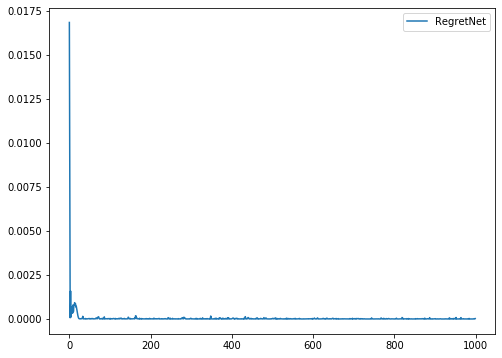

In [ ]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(report.groupby('epoch')[['total_ir_violation']].mean(), label='RegretNet');
ax.legend();

Next, let's review the DSIC violations. RegretNet quickly optimizes to relatively small violations.

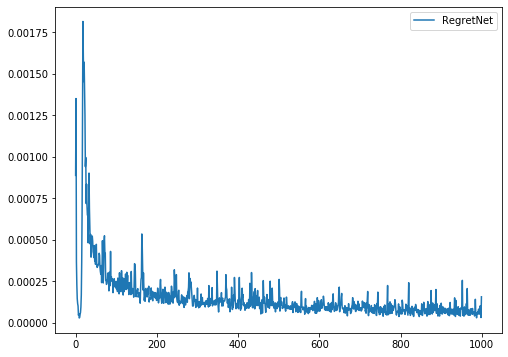

In [ ]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(report.groupby('epoch')[['total_dsic_violation']].mean(), label='RegretNet');
ax.legend();

Finally, let's review the revenue.  RegretNet quickly converges to the optimal revenue.  Note that in this case, the expected revenue is above the optimal revenue.  The implication is that RegretNet has found a solution that is almost DSIC and IR, but not quite.

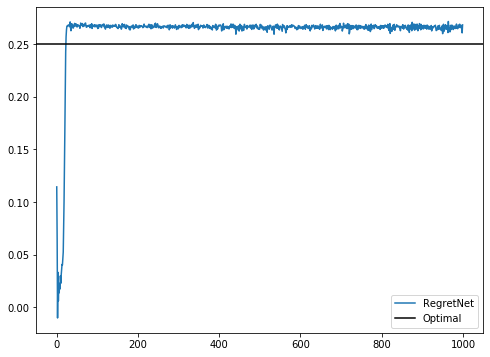

In [ ]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(report.groupby('epoch')[['revenue']].mean(), label='RegretNet');
ax.axhline(0.25, c='k', label='Optimal')
ax.legend();

Let's review how the network responds to inputs.  We see that the mechanism allocates with probability increasing in bid and that there is a near stepwise transition that appears close to 0.5 (as with Myerson).  The price of allocated goods are near 0.5 (as with Myerson).

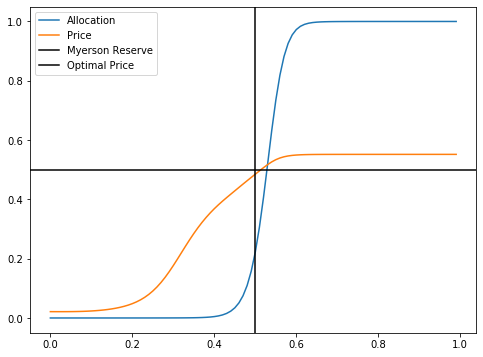

In [ ]:
one_bidder_bids = torch.tensor(np.arange(0,1,0.01)).float().to(device).unsqueeze(dim=-1)
one_bidder_allocation, one_bidder_payments = regret_net(one_bidder_bids)
one_bidder_price = one_bidder_payments/one_bidder_allocation

fig, ax = plt.subplots(figsize=(8,6));
ax.plot(one_bidder_bids.detach().cpu().numpy(), one_bidder_allocation.detach().cpu().numpy(), label='Allocation');
ax.plot(one_bidder_bids.detach().cpu().numpy(), one_bidder_price.detach().cpu().numpy(), label='Price');

ax.axvline(0.5, c='k', label='Myerson Reserve')
ax.axhline(0.5, c='k', label='Optimal Price')

ax.legend();

### Two Bidders

For our second warmup exercise, we consider a single-item auction for two bidder.  From Myerson (81), we know that the optimal mechanism is equivalent to using a reserve price of 0.5.  Since the bidders values are drawn from uniformly from [0,1], we know that half of the draws will result in the bidder not winning the item, with the other half winning at a price of  $max \{0.5,opponent\} $.  Therefore, the optimal expected revenue is 5/12.

In [ ]:
bidders = 2

Again, the networks will train on data that is sampled from the value distribution, which is loaded into a `DataLoader`.

In [ ]:
sample_size = 10 #2**11
batch_size = 3 #2**8

inputs_loader=data_utils.DataLoader(
    data_utils.TensorDataset(torch.rand(sample_size, bidders)),
    batch_size=batch_size)

data_list = []
for batch_idx, batch in enumerate(inputs_loader):
    data_list.append(batch[0].numpy())

# Concatenate the data and create a DataFrame
data = np.concatenate(data_list, axis=0)
df = pd.DataFrame(data)

print(df)

          0
0  0.204759
1  0.160062
2  0.020282
3  0.586993
4  0.401375
5  0.317340
6  0.218691
7  0.501284
8  0.739915
9  0.907508


We again initialize the mechanism using the builder.

In [ ]:
regret_net = create_regret_net(bidders).to(device)

AttributeError: module 'dmch' has no attribute 'build_mechanism'

As above, we loop over the data for a number of epochs and record traces of the networks learning.

In [ ]:
report = pd.DataFrame(dmch.train(
    regret_net, # the mechanism
    inputs_loader, # the bid inputs
    bidders, # the number of bidders
    epochs=1000, # the total number of loops over the data
    device=device, # the device
    rho=1e2, # the rho parameter for the augmented Lagrangian method
    mechanism_lr=1e-2, # the learning rate for the mechanism networks
    misreport_lr=1e-1, # the learning rate for the misreport tensor
    misreport_epochs=10)) # the number of epochs to tune the misreport tensor for each batch

AttributeError: module 'dmch' has no attribute 'train'

RegretNet converges to small IR violation.

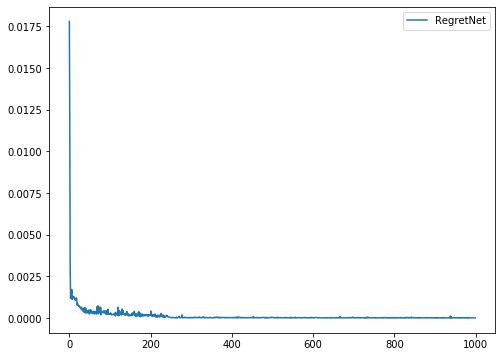

In [ ]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(report.groupby('epoch')[['total_ir_violation']].mean(), label='RegretNet');
ax.legend();

As before, RegretNet settles into low DCIS violation.

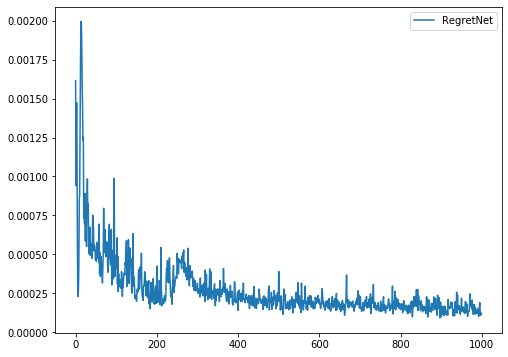

In [ ]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(report.groupby('epoch')[['total_dsic_violation']].mean(), label='RegretNet');
ax.legend();

Finally, RegretNet converges to near optimal revenue.

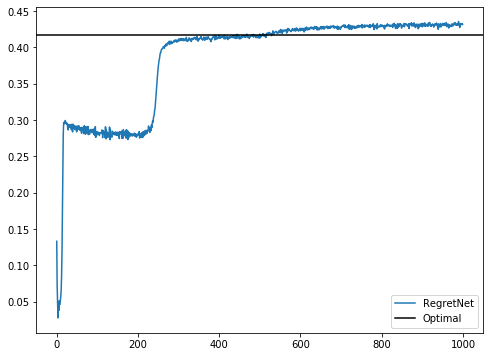

In [ ]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(report.groupby('epoch')[['revenue']].mean(), label='RegretNet');
ax.axhline(5/12, c='k', label='Optimal')
ax.legend();

Let's review how the network responds to inputs.  We see that the mechanism allocates with probability increasing in bid (with the other bidder constant) and that there is a near stepwise transition that appears close to 0.5 (as with Myerson) with the item allocated with increasing probability towards the highest bidder when both bid above 0.5.

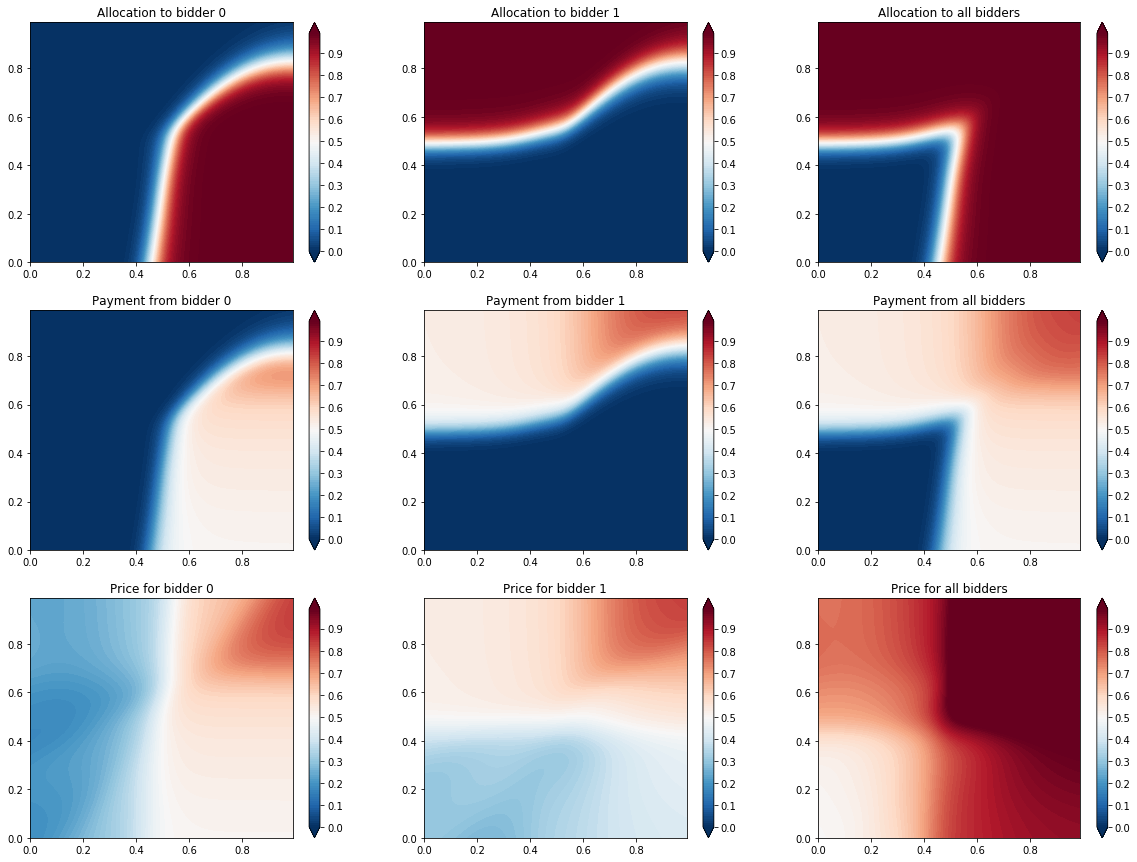

In [ ]:
def plot_mechanism(mechanism):
    X, Y = np.meshgrid(
        np.arange(0.0, 1.0, 0.01),
        np.arange(0.0, 1.0, 0.01))
    
    inputs = torch.cat(
        (torch.from_numpy(np.reshape(X, (100*100,1))),
         torch.from_numpy(np.reshape(Y, (100*100,1)))),
        dim=1).float().to(device)
    allocation, payment = mechanism(inputs)
    levels = np.arange(0, 1.0, 0.01)
    fig, axes = plt.subplots(nrows=3, ncols=bidders+1, figsize=(20,15));
    
    def plot_contour(tensor,axis_index,bidder_title,main_title):
        for bidder in range(bidders):
            CS = axes[axis_index,bidder].tricontourf(
                inputs[:,0].cpu().numpy(),
                inputs[:,1].cpu().numpy(),
                tensor[:,bidder].detach().cpu().numpy(),
                levels=levels,
                cmap="RdBu_r",
                extend='both');
            fig.colorbar(CS, ax=axes[axis_index,bidder]);
            axes[axis_index,bidder].set_title(bidder_title+str(bidder));
        CS = axes[axis_index,bidders].tricontourf(
            inputs[:,0].cpu().numpy(),
            inputs[:,1].cpu().numpy(),
            tensor.sum(dim=1).detach().cpu().numpy(),
            levels=levels,
            cmap="RdBu_r",
            extend='both');
        fig.colorbar(CS, ax=axes[axis_index,bidders]);
        axes[axis_index,bidders].set_title(main_title);
    plot_contour(allocation,0,'Allocation to bidder ','Allocation to all bidders')
    plot_contour(payment,1,'Payment from bidder ','Payment from all bidders')
    plot_contour(payment/allocation,2,'Price for bidder ','Price for all bidders')

plot_mechanism(regret_net)